# Trader Performance vs Market Sentiment

Objective:
Analyze how Bitcoin market sentiment (Fear/Greed) impacts trader behavior and performance on Hyperliquid.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

pd.set_option("display.max_columns", None)
np.random.seed(42)


In [9]:
sent = pd.read_csv("../data/fear_greed_index.csv")
trades = pd.read_csv("../data/historical_data.csv")

print("Sentiment Shape:", sent.shape)
print("Trades Shape:", trades.shape)

sent.head()

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [10]:
print("Sentiment Missing Values:\n", sent.isna().sum())
print("\nTrades Missing Values:\n", trades.isna().sum())

print("\nSentiment Duplicates:", sent.duplicated().sum())
print("Trades Duplicates:", trades.duplicated().sum())


Sentiment Missing Values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades Missing Values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Sentiment Duplicates: 0
Trades Duplicates: 0


In [11]:
sent['date'] = pd.to_datetime(sent['date'])

# Merge Extreme Fear into Fear
sent['sentiment'] = sent['classification'].replace({
    'Extreme Fear': 'Fear'
})

sent = sent[sent['sentiment'].isin(['Fear', 'Greed'])]
sent = sent[['date','sentiment']]

sent.head()


,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Fear
2,2018-02-03,Fear
3,2018-02-04,Fear
4,2018-02-05,Fear


In [13]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

numeric_cols = ['Execution Price','Size Tokens','Size USD','Closed PnL','Fee']

for col in numeric_cols:
    trades[col] = pd.to_numeric(trades[col], errors='coerce')

trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02


In [14]:
closing_trades = trades[trades['Closed PnL'] != 0].copy()

print("Total trades:", len(trades))
print("Closing trades:", len(closing_trades))

Total trades: 211224
Closing trades: 104408


In [15]:
daily_metrics = closing_trades.groupby(['date','Account']).agg(
    daily_pnl=('Closed PnL','sum'),
    trades_per_day=('Closed PnL','count'),
    win_rate=('Closed PnL', lambda x: (x>0).sum()/len(x)),
    avg_trade_size=('Size USD','mean')
).reset_index()

daily_metrics.head()

,date,Account,daily_pnl,trades_per_day,win_rate,avg_trade_size
0,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,6,0.666667,12789.398333
1,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,2,0.000000,5304.975000
2,2023-12-17,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,304.982785,11,0.636364,5996.891818
3,2023-12-19,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,1000.538612,10,1.000000,6188.349000
4,2023-12-20,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,162.732282,8,1.000000,8862.468750


In [16]:
daily_metrics = daily_metrics.merge(sent, on='date', how='left')
daily_metrics = daily_metrics.dropna(subset=['sentiment'])

daily_metrics.head()

,date,Account,daily_pnl,trades_per_day,win_rate,avg_trade_size,sentiment
0,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,6,0.666667,12789.398333,Greed
1,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,2,0.000000,5304.975000,Greed
2,2023-12-17,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,304.982785,11,0.636364,5996.891818,Greed
3,2023-12-19,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,1000.538612,10,1.000000,6188.349000,Greed
4,2023-12-20,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,162.732282,8,1.000000,8862.468750,Greed


# PART B — ANALYSIS

In [17]:
summary = daily_metrics.groupby('sentiment')['daily_pnl'].describe()
summary

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Fear,572.0,7161.303654,36510.169054,-108604.496278,59.630439,662.961053,3677.424139,533974.662903
Greed,448.0,4799.395699,36716.519066,-358963.139984,123.513473,803.968004,2573.163946,375620.270243


In [18]:
summary.to_csv("../results/pnl_summary_by_sentiment.csv")

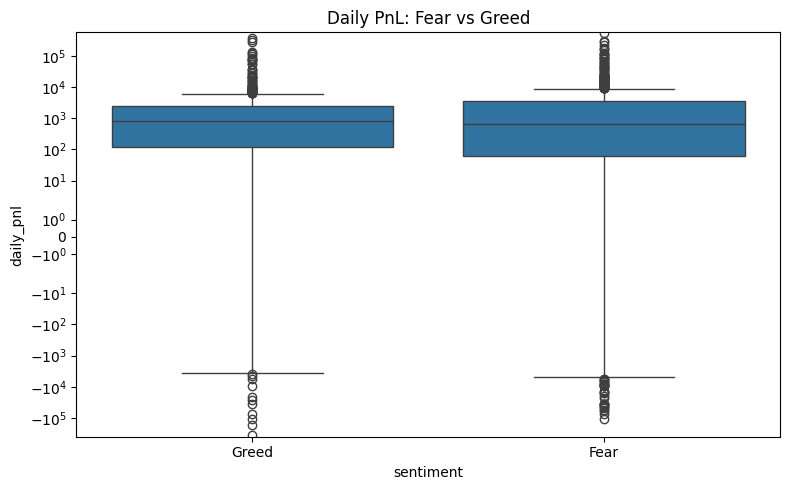

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(data=daily_metrics, x='sentiment', y='daily_pnl')
plt.yscale('symlog')
plt.title("Daily PnL: Fear vs Greed")
plt.tight_layout()
plt.savefig("../results/fig_pnl_by_sentiment.png")
plt.show()


In [20]:
fear_pnl = daily_metrics[daily_metrics['sentiment']=='Fear']['daily_pnl']
greed_pnl = daily_metrics[daily_metrics['sentiment']=='Greed']['daily_pnl']

stat, p_value = stats.mannwhitneyu(fear_pnl, greed_pnl)

print("Mann-Whitney U p-value:", p_value)

Mann-Whitney U p-value: 0.7683157437119043


In [21]:
behavior_summary = daily_metrics.groupby('sentiment')[
    ['trades_per_day','win_rate','avg_trade_size']
].mean()

behavior_summary


,trades_per_day,win_rate,avg_trade_size
sentiment,,,
Fear,70.304196,0.842294,11593.062681
Greed,56.196429,0.846074,7194.089772


In [22]:
behavior_summary.to_csv("../results/behavior_summary.csv")


In [23]:
threshold_high = daily_metrics['avg_trade_size'].quantile(0.75)
threshold_low = daily_metrics['avg_trade_size'].quantile(0.25)

def risk_segment(x):
    if x >= threshold_high:
        return "High Risk"
    elif x <= threshold_low:
        return "Low Risk"
    else:
        return "Medium"

daily_metrics['risk_segment'] = daily_metrics['avg_trade_size'].apply(risk_segment)

segment_analysis = daily_metrics.groupby(['risk_segment','sentiment'])['daily_pnl'].mean().unstack()

segment_analysis


sentiment,Fear,Greed
risk_segment,,
High Risk,15104.422450,9857.232707
Low Risk,271.920383,617.028058
Medium,6360.404843,4585.908574


In [24]:
segment_analysis.to_csv("../results/segment_analysis.csv")


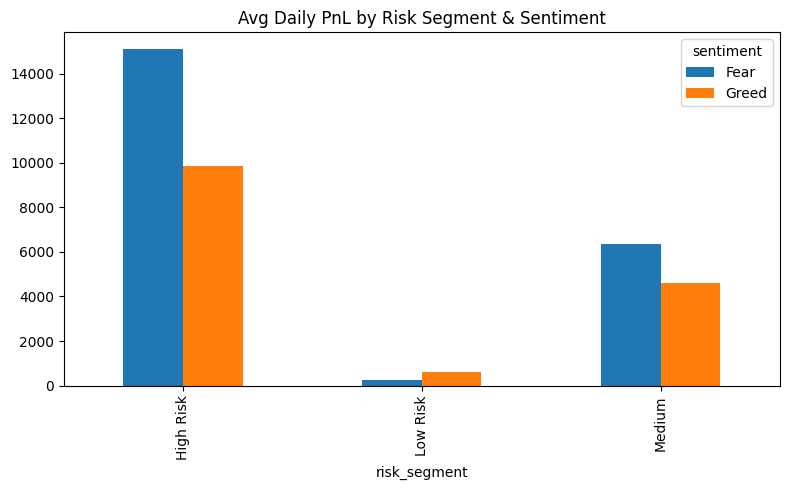

In [25]:
segment_analysis.plot(kind='bar', figsize=(8,5))
plt.title("Avg Daily PnL by Risk Segment & Sentiment")
plt.tight_layout()
plt.savefig("../results/fig_segment_analysis.png")
plt.show()


In [26]:
# Filter high risk segment
high_risk = daily_metrics[daily_metrics['risk_segment'] == "High Risk"]

fear_hr = high_risk[high_risk['sentiment'] == "Fear"]['daily_pnl']
greed_hr = high_risk[high_risk['sentiment'] == "Greed"]['daily_pnl']

print("High Risk - Fear mean:", fear_hr.mean())
print("High Risk - Greed mean:", greed_hr.mean())

stat, p_value_hr = stats.mannwhitneyu(fear_hr, greed_hr)

print("High Risk Mann-Whitney p-value:", p_value_hr)


High Risk - Fear mean: 15104.422450372413
High Risk - Greed mean: 9857.232707327274
High Risk Mann-Whitney p-value: 0.024338008657771294


In [27]:
volatility = daily_metrics.groupby('sentiment')['daily_pnl'].std()
volatility


sentiment
Fear     36510.169054
Greed    36716.519066
Name: daily_pnl, dtype: float64

In [28]:
high_risk_vol = high_risk.groupby('sentiment')['daily_pnl'].std()
high_risk_vol


sentiment
Fear     57818.691616
Greed    54733.435117
Name: daily_pnl, dtype: float64

In [29]:
risk_adjusted = daily_metrics.groupby('sentiment')['daily_pnl'].mean() / \
                daily_metrics.groupby('sentiment')['daily_pnl'].std()

risk_adjusted


sentiment
Fear     0.196145
Greed    0.130715
Name: daily_pnl, dtype: float64

## Final Interpretation

While overall trader profitability does not significantly differ across sentiment regimes, segment-level analysis reveals that high-risk traders benefit from Fear environments.

This suggests sentiment interacts with risk profile rather than directly determining profitability.

Fear regimes appear to create volatility-driven opportunities that high-risk traders exploit more effectively.


Predict whether next day will be profitable (binary classification).

No deep learning.
Just logistic regression.

In [36]:
# Sort by account and date
daily_metrics = daily_metrics.sort_values(['Account','date'])

# Create next-day profitability target
daily_metrics['next_day_profitable'] = daily_metrics.groupby('Account')['daily_pnl'].shift(-1)
daily_metrics['next_day_profitable'] = (daily_metrics['next_day_profitable'] > 0).astype(int)

# Drop last day per account (no next day)
model_df = daily_metrics.dropna(subset=['next_day_profitable'])

# Encode sentiment
model_df['sentiment_encoded'] = model_df['sentiment'].map({
    'Fear': 0,
    'Greed': 1
})

features = ['trades_per_day','win_rate','avg_trade_size','sentiment_encoded']
X = model_df[features]
y = model_df['next_day_profitable']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.82      1.00      0.90       252

    accuracy                           0.82       306
   macro avg       0.41      0.50      0.45       306
weighted avg       0.68      0.82      0.74       306

ROC-AUC: 0.570840681951793


C:\Users\Anirudha Thakur\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Anirudha Thakur\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Anirudha Thakur\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag